In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import seaborn as sns

np.random.seed(84)

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

out_data_path = "../data/"

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.5 pynndescent==0.5.10


### Load the Data

In [3]:
# Load the data from the 2_dataprocessing script
processed_data_path = out_data_path + "processed_ad.h5ad"
adata = ad.read_h5ad(processed_data_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 20248 × 30267
    obs: 'dataset', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'scrublet'

### Cell Cycle Identification and Regression

In [5]:
# S genes and G2M genes were taking from the Seurat pipeline
s_genes = ["MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", "MCM6", "CDCA7", "DTL", 
           "PRIM1", "UHRF1", "MLF1IP", "HELLS", "RFC2", "RPA2", "NASP", "RAD51AP1", "GMNN", "WDR76", "SLBP", 
           "CCNE2", "UBR7", "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", 
           "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"]   

g2m_genes = ["HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80", "CKS2", "NUF2", "CKS1B", 
             "MKI67", "TMPO", "CENPF", "TACC3", "FAM64A", "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", 
             "KIF11", "ANP32E", "TUBB4B", "GTSE1", "KIF20B", "HJURP", "CDCA3", "HN1", "CDC20", "TTK", "CDC25C", 
             "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5", "CDCA2", "CDCA8", "ECT2", "KIF23", "HMMR", "AURKA", "PSRC1", 
             "ANLN", "LBR", "CKAP5", "CENPE", "CTCF", "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA"]

In [6]:
cell_cycle_genes = s_genes + g2m_genes
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [7]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    387 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    430 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:17)


/Users/nellia/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


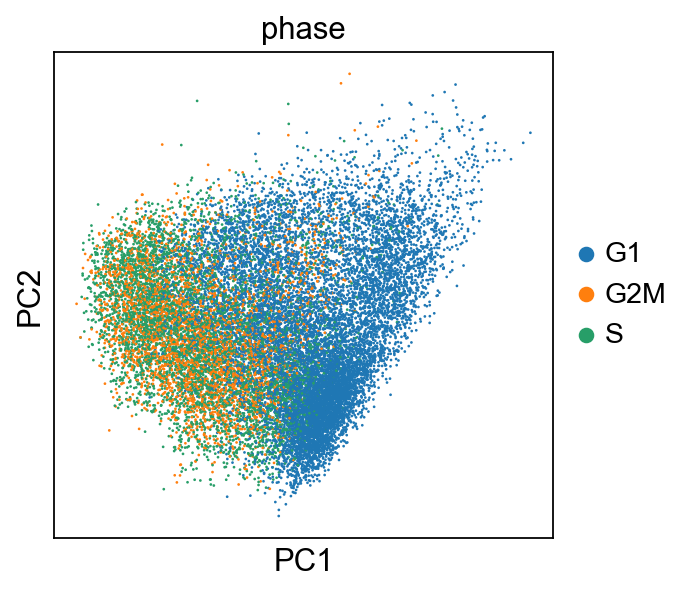

In [8]:
# Scale data and run PCA. Check the PCA plot based on Phase
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack', random_state=84)
sc.pl.pca_scatter(adata,color='phase')

In [9]:
# Run the UMAP algorithm
sc.pp.neighbors(adata,n_neighbors=80, n_pcs=20,random_state=84)
sc.tl.leiden(adata, random_state=84)
sc.tl.umap(adata,random_state=84)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


/Users/nellia/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


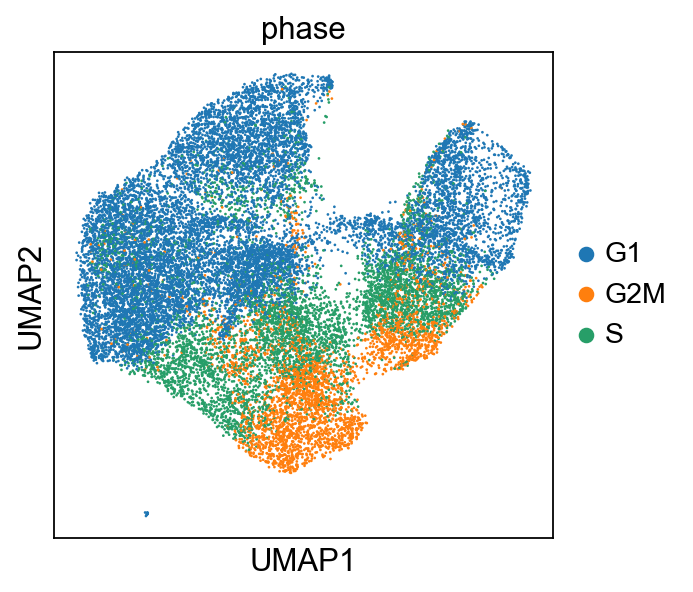

In [10]:
# Plot the UMAP coloured by phase to check for cell cycle bias
sc.pl.umap(adata, color="phase")

### Regression

In [11]:
# Regress out cell cycle
sc.pp.regress_out(adata, ['S_score', 'G2M_score'], n_jobs=6)

regressing out ['S_score', 'G2M_score']
    finished (0:03:01)


computing PCA
    with n_comps=50
    finished (0:00:20)


/Users/nellia/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


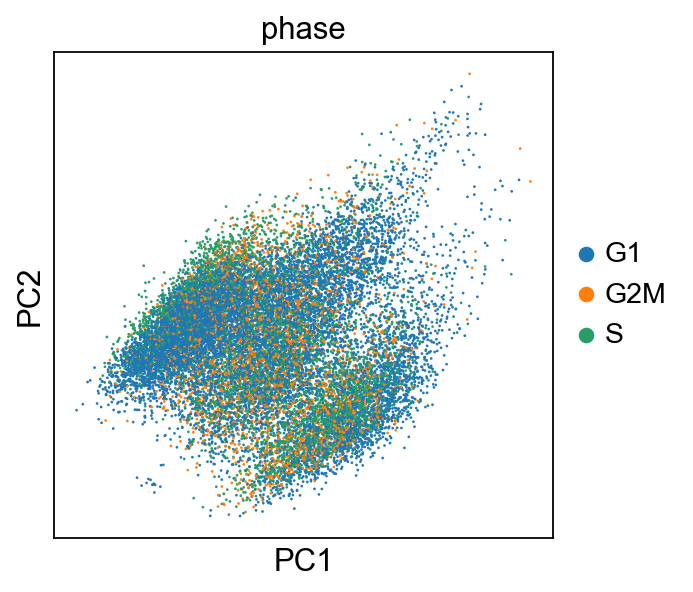

In [12]:
# Rerun the PCA on the regressed data
sc.tl.pca(adata, svd_solver='arpack',random_state=84)
sc.pl.pca(adata,color='phase')

In [13]:
# Rerun the UMAP on the regressed data
sc.pp.neighbors(adata,n_neighbors=80, n_pcs=20,random_state=84)
sc.tl.leiden(adata,random_state=84)
sc.tl.umap(adata,random_state=84)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:54)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


/Users/nellia/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


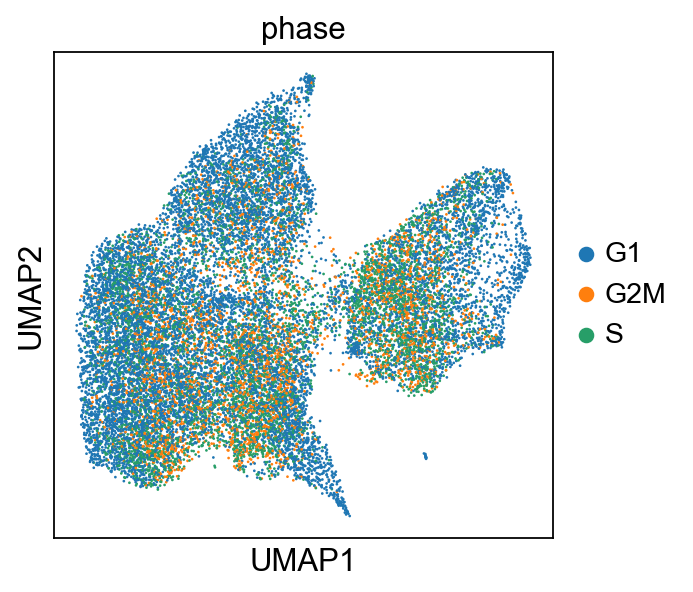

In [14]:
# Check for the cell cycle bias in the new data
sc.pl.umap(adata, color="phase")

/Users/nellia/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


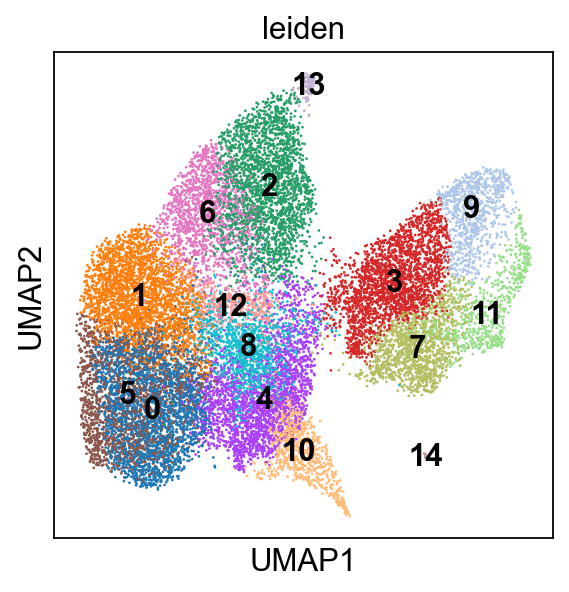

In [15]:
# Visualise the clustering
sc.pl.umap(adata, color="leiden", legend_loc="on data")

### Regressed output

In [16]:
# Output regressed data
regressed_data_path = out_data_path + "regressed_ad.h5ad"
adata.write_h5ad(regressed_data_path)